In [7]:
import numpy as np
import pickle
import time

from src.data.make_dataset import generate_dataset
from src.models.train_model import BO_loop, grid_search, dist_loop
from src.models.acquisition import Random, MaxVariance

from functools import partial

=== iter 0, ((4, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  
=== iter 1, ((5, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  
=== iter 2, ((6, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  
=== iter 3, ((7, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  
=== iter 4, ((8, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  
=== iter 5, ((9, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  
=== iter 6, ((10, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  
=== iter 7, ((11, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  
=== iter 8, ((12, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  
=== iter 9, ((13, 4)) -- cpt 0 -- cpt 1 -- cpt 2 -- cpt 3  


TypeError: file must have a 'write' attribute

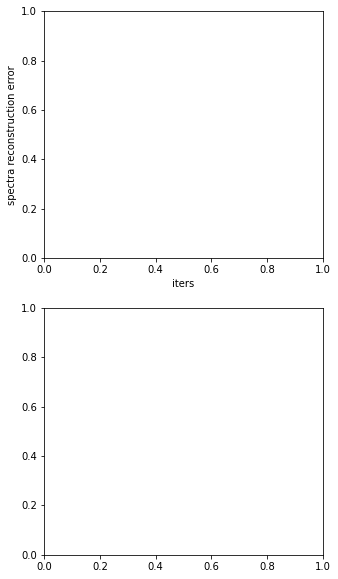

In [3]:
# run trig basis tests
iters = 5
rng = np.random.default_rng(seed = 42)
data_seeds = rng.integers(low=0, high=10000, size=iters)

ds_cfg = {'n_cpts': 5, 'supply_truth':False, 'basis':'trig'}
bo_cfg = {'pca_cpts': 4, 'bo_iters':10}

mv_bo_loop = partial(BO_loop, acq_func=MaxVariance )
rand_bo_loop = partial(BO_loop, acq_func=Random )
loops = [grid_search, dist_loop, mv_bo_loop, rand_bo_loop]

for s in data_seeds:
    face_image, data, x_vals = generate_dataset(n_cpts=ds_cfg['n_cpts'], 
                                seed=s, supply_truth=ds_cfg['supply_truth'],
                                xanes=ds_cfg['basis'])
    for loop in loops:
        # run test
        print(loop.__name__)
        ts = time.time()
        _, varis, errs, info_dict = loop(data, n_cpts=bo_cfg['pca_cpts'], 
                                        n_iters=bo_cfg['bo_iters'])

        # construct results dictionary and save
        results = {'max_variances': varis,
                    'errors': errs,
                    'info_dict': info_dict,
                    'bo_cfg': bo_cfg,
                    'ds_cfg': ds_cfg,
                    'start_time': ts
                    }

        with open(f'results_{ds_cfg["basis"]}_{s}.pkl', 'wb') as f:
            pickle.dump(results, f)    

In [5]:
loop.__name__

'grid_search'

In [ ]:
import pickle
with open('testdump.pkl', 'wb') as f:
    pickle.dump({'vars':[1,2,3,4], 'error':['tester']}, f)

with open('testdump.pkl', 'rb') as ff:
    a = pickle.load(ff)

print(a.keys())